## DQN Atari Breakout (using a Convolutional Neural Network)
This code is based on the *Lecture 6* from the excelent [course on Reinforcement Learning](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html) by David Silver.

It implements a Neural Network to learn the Atari game Breakout
TD learning with fixed Q-target and Experience Replay.

In [1]:
import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import gym

from IPython.display import clear_output
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
%matplotlib inline

Number of possible actions: 4
Number of possible states: Box(210, 160, 3)


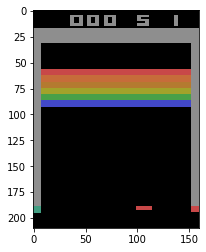

In [2]:
"""

""" 

ENV_NAME = "Breakout-v0"

env = gym.make(ENV_NAME)

print("Number of possible actions:", env.action_space.n)
print("Number of possible states:", env.observation_space)

env.reset()
plt.imshow(env.render("rgb_array"))

In [3]:
import atari_wrappers

def make_env(seed=None):
    env = gym.make(ENV_NAME)
    if seed is not None:
        env.seed(seed)
    env = atari_wrappers.wrap_Breakout(env, episode_life=True, clip_rewards=True, frame_stack=True, scale=False)
    return env

env = make_env()
env.reset()
n_actions = env.action_space.n
print("Observation shape:", env.observation_space.shape)


Observation shape: (4, 64, 64)


/home/elisio/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Observation shape: (4, 64, 64)



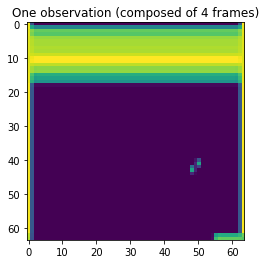

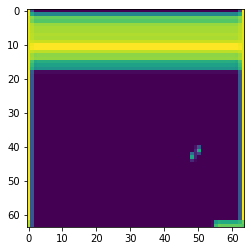

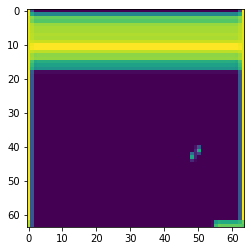

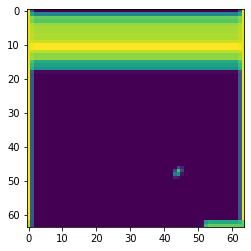

In [4]:
observ, _, _, _ = env.step(env.action_space.sample())

print("Observation shape:", env.observation_space.shape)
print()
plt.title("One observation (composed of 4 frames)")
plt.imshow(observ[0])
plt.show()
plt.imshow(observ[1])
plt.show()
plt.imshow(observ[2])
plt.show()
plt.imshow(observ[3])
plt.show()


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [6]:
class DQNAgent(nn.Module):
    def __init__(self, n_action_space, n_observation_space, epsilon):
        super().__init__()
        self.n_action_space = n_action_space
        self.n_observation_space = n_observation_space
        
        self.epsilon = epsilon
               
        # batch shape = batch_size x 4 x height x width
        # the 4 is due to the 4 frames that are processed at the same time
        # check MaxAndSkipEnv wrapper above
        self.network = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, stride=2), #in=4x64x64 out=16x31x31
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2), #in=16x31x31 out=32x15x15
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, stride=1), #in=32x15x15 out=64x14x14
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=2), #in=64x14x14 out=128x7x7
            torch.nn.ReLU(),
            torch.nn.Flatten(),
            torch.nn.Linear(7*7*128, n_action_space),
            
            torch.nn.ReLU()
        )
    def forward(self, state):
        
        qvalues = self.network(state)

        return qvalues
    
    def get_action_epsilon_greedy(self, qvalues):    
        # the action returned either will be random or the greedy
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.n_action_space) # return a random action
        else: # else, be greedy
            action = np.argmax(qvalues)
        return action
   
    def get_greedy_action(self, qvalues):
            return np.argmax(qvalues)
    
    def get_qvalues(self, state):
        state = torch.tensor([state], dtype=torch.float, device=device) # add batch dimension (=1) to state
        return self.forward(state).cpu().detach().numpy()
   

In [7]:
def calculate_loss(state_batch, action_batch, new_state_batch, reward_batch, done_batch, discount_factor):
    # convert variables to tensor
    state_batch = torch.tensor(state_batch, dtype=torch.float, device=device)
    new_state_batch = torch.tensor(new_state_batch, dtype=torch.float, device=device)
    reward_batch = torch.tensor(reward_batch, dtype=torch.float, device=device)
    done_batch = torch.tensor(done_batch, dtype=torch.uint8, device=device)
    
    not_done_batch = 1 - done_batch

    # predict all q-values for current state
    all_qvalues_state = agent(state_batch)
    #print(state_batch.shape)
    #l

    # select the q_value for the agent action
    qvalue_state = all_qvalues_state[range(len(all_qvalues_state)), action_batch]
    
    # predict all q-values for the new state 
    all_qvalues_new_state = target(new_state_batch)

    # select the q-value for the new state for the action that maximises it, q'(s',amax)
    qvalue_new_state = torch.tensor([torch.max(all_qvalues_new_state[i]).item() for i in range(len(all_qvalues_new_state))],
                                     dtype=torch.float32, device=device)
    
    # for TD target if it's a terminal state (done == 1) the target receives only the value of the reward
    # not_done_batch is a vector that when multiplied by the value function does that job.
    td_target = reward_batch + discount_factor*qvalue_new_state*not_done_batch

    # loss = MSE (mean squared error) of TD error (Q-network - Q-learning targets)
    # the detach is a way to fix the target network by not having its gradients computed
    loss = F.mse_loss(qvalue_state, td_target.detach())

    return loss

In [8]:
def populate_memory(memory_size):
    
    state = env.reset()
    total_reward = 0.0
    
    for _ in range(memory_size):
        qvalues = agent.get_qvalues(state) # get qvalues for current state
        action = agent.get_action_epsilon_greedy(qvalues) # get action based on e-greedy policy
        
        new_state, reward, done, info = env.step(action)
        
        # record current step variables
        memory.push(state, action, new_state, reward, done)
            
        state = env.reset() if done else new_state
            
        total_reward += reward
        
    return total_reward/memory_size

In [9]:
def validation_test(env_val, n_episodes=10):
    #env_val = gym.make(ENV_NAME).env
    #env_val = make_env()
    total_reward = []
    
    for _ in range(n_episodes):
        state = env_val.reset()
        done = False
        ep_rewards = 0.0
        
        while not done:
            qvalues = agent.get_qvalues(state) # get qvalues for current state
            action = agent.get_greedy_action(qvalues)
            new_state, reward, done, info = env_val.step(action)
            state = new_state
            
            ep_rewards += reward

        total_reward.append(ep_rewards)

    return np.mean(total_reward)

In [10]:
# https://github.com/openai/baselines/blob/master/baselines/deepq/replay_buffer.py
class ReplayMemory:
    def __init__(self, capacity):
        self._capacity = capacity
        self._memory = []
        self._position = 0
    
    def push(self, state, action, new_state, reward, done):
        if len(self._memory) < self._capacity:
            self._memory.append(None)
        self._memory[self._position] = (state, action, new_state, reward, done)
        self._position = (self._position + 1) % self._capacity
        
    # pop batchs for each variable
    def pop(self, batch_size):
        idxes = [random.randint(0, len(self._memory) - 1) for _ in range(batch_size)]
        st_all, ac_all, nst_all, rw_all, dn_all = [], [], [], [], []
        for i in idxes:
            sample = self._memory[i]
            st_t, ac_t, nst_t, rw_t, dn_t = sample
            # by not copying the data the training speeds up dramatically
            st_all.append(np.array(st_t, copy=False)) 
            ac_all.append(np.array(ac_t, copy=False))
            nst_all.append(np.array(nst_t, copy=False))
            rw_all.append(np.array(rw_t, copy=False))
            dn_all.append(np.array(dn_t, copy=False))
        return np.array(st_all), np.array(ac_all), np.array(nst_all), np.array(rw_all), np.array(dn_all)
   
    def __len__(self):
        return len(self._memory)

In [11]:
# hyperparameters
init_epsilon = 1
final_epsilon = 0.1

discount_factor = 0.99
memory_size = 10000
batch_size = 16

#epochs = 3000000
epochs = 1500000

update_target_rate = 5000 # rate that the target network will be updated

agent = DQNAgent(n_action_space=env.action_space.n, 
                 n_observation_space=env.observation_space.shape, 
                 epsilon=init_epsilon).to(device) 

target = DQNAgent(n_action_space=env.action_space.n, 
                  n_observation_space=env.observation_space.shape, 
                  epsilon=init_epsilon).to(device)

target.load_state_dict(agent.state_dict())

memory = ReplayMemory(memory_size)

In [12]:
learning_rate = 0.0001
optimiser = torch.optim.Adam(agent.parameters(), lr=learning_rate)

In [13]:
# play some games to fill the memory
print("Memory size:", len(memory))
rewards = populate_memory(memory_size)
print("Memory size:", len(memory))
print("Rewards:", rewards)

Memory size: 0
Memory size: 10000
Rewards: 0.0303


In [14]:
def optimize():    
    state_batch, action_batch, new_state_batch, reward_batch, done_batch = memory.pop(batch_size)
    
    loss = calculate_loss(state_batch, action_batch, new_state_batch, reward_batch, done_batch, discount_factor)
    
    loss.backward() # calculate the sum of gradients
    optimiser.step() # update model's parameters
    optimiser.zero_grad() # set gradients to zero
    
    return loss.detach().cpu().item()

Progress 100.00% (Epoch 1500000 from 1500000) 	 epsilon 0.10


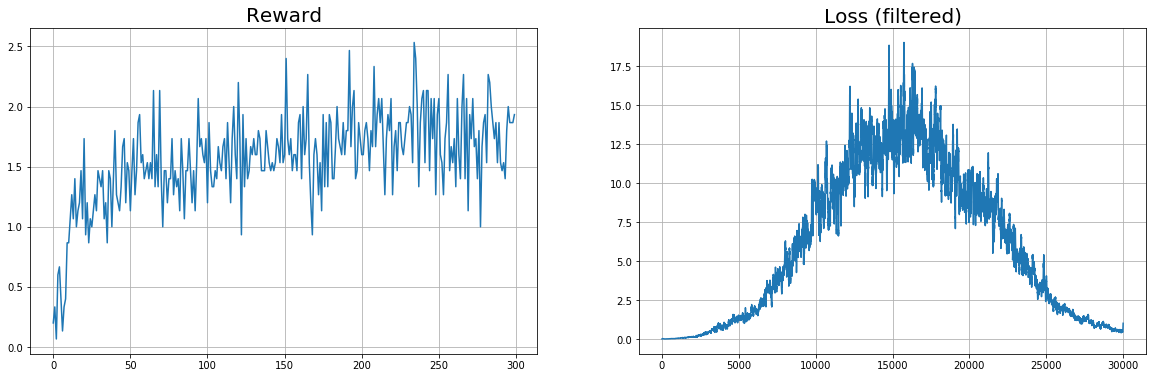

100%|██████████| 1500000/1500000 [4:00:22<00:00, 104.00it/s]


In [15]:
from tqdm import trange

state = env.reset()

total_loss = []
total_reward = []

# a constant to decrement the epsilon at each iteration
epsilon_discount_value = (init_epsilon-final_epsilon)/epochs

state = env.reset()

for epoch in trange(1, epochs+1):
    
    qvalues = agent.get_qvalues(state) # get qvalues for current state
    action = agent.get_action_epsilon_greedy(qvalues) # get action based on e-greedy policy

    new_state, reward, done, info = env.step(action)

    # record current step variables
    memory.push(state, action, new_state, reward, done)
    
    state = env.reset() if done else new_state
    
    loss = optimize()
   
   
    # save loss for plot
    if epoch % 50 == 0:
        total_loss.append(loss)
   
    # update epsilon
    agent.epsilon -= epsilon_discount_value
    
    # update target network with weights from 
    if epoch % update_target_rate == 0:
        target.load_state_dict(agent.state_dict())
        
    if epoch % 5000 == 0:
        total_reward.append(validation_test(make_env(np.random.randint(0, epoch)), n_episodes=3*5)) # 5 = number of lives of each episode
        
        clear_output(True)
        print("Progress {:.2f}% (Epoch {} from {}) \t epsilon {:.2f}".format(epoch*100/epochs, epoch, epochs, agent.epsilon))
        plt.figure(figsize=[20, 6])
        
        plt.subplot(1, 2, 1)
        plt.title("Reward", fontsize=20)
        plt.plot(total_reward)
        plt.grid()
        
        plt.subplot(1, 2, 2)
        plt.title("Loss (filtered)", fontsize=20) # Savitzky-Golay filter https://stackoverflow.com/a/20642478
        #print("len x:", len(total_loss))
        plt.plot(savgol_filter(total_loss, 99, 3))
        plt.grid()

        plt.show()

In [16]:
# test trained agent
reward = validation_test(make_env(), n_episodes=10)
print("Mean reward for 10 games:", reward)

Mean reward for 10 games: 1.3


In [17]:
# play some games with the trained agent
from gym import wrappers
dir_videos = "./gym-results"

env_monitor = wrappers.Monitor(make_env(), directory=dir_videos, force=True)

for _ in range(10):
    validation_test(env_monitor, n_episodes=5)
env_monitor.close()

In [18]:
# display video on page
from IPython.display import HTML
import glob
import os

video_names = list(
    filter(lambda s: s.endswith(".mp4"), os.listdir("./videos/")))
recorded_videos = glob.glob(os.path.join(dir_videos, '*.mp4'))
print(recorded_videos)

HTML("""<video width="640" height="480" controls>
  <source src="{}" type="video/mp4"> </video>""".format(recorded_videos[-1]))

['./gym-results/openaigym.video.0.7146.video000000.mp4', './gym-results/openaigym.video.0.7146.video000027.mp4', './gym-results/openaigym.video.0.7146.video000001.mp4', './gym-results/openaigym.video.0.7146.video000008.mp4']


In [19]:
torch.save(agent.state_dict(), "./agent_breakout.pt")